# Restricted Boltzmann Machine Learning with Mean-Field Methods

A tutorial for VDSP-ESI Winter School 2020: Machine Learning in Physics. <br/>

by Marylou Gabrié (NYU - Flatiron Institute) & Alia Abbara (ENS)

### Table of content

1. [The RBM Object](#class)
2. [Monte Carlo Markov Chain Training](#mcmc)
3. [Naive Mean-field Training](#nmf) <br/> 
    3.1 Mean-field approximation of the log-likelihood<br/> 
    3.2 Training implementation 
4. [Thouless-Anderson-Palmer Training](#tap)
3. [Comparison](#comp)

### Jupyter notebook start-up

To start off the tutorial, a lot of functions are readily provided. You should observe and understand these functions. 
They will be a good starting point for the cases you will have to code up yourself.

We start by 
- charging useful module and options
- load the MNIST dataset for experiments
- define useful functions for the rest of the tutorial

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
import matplotlib.pyplot as plt
import pickle
from keras.datasets import mnist

# prepare binary MNIST training images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train[x_train > 0] = 1
x_train = np.reshape(x_train, (x_train.shape[0], 784))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prepare_batches(x_train, batch_size):
    batches = x_train.shape[0]//batch_size
    batch_list = []
    for batch in range(batches):
        x_batch = x_train[batch*batch_size: (batch+1)*batch_size, :]
        batch_list.append(x_batch)
    return batch_list
        

Using TensorFlow backend.


<a id=class><a/>

# 1. The RBM object

We create an python class to store and manipulate models of RBMs.

In [2]:
class RBM:
    def __init__(self, N, M, eta=1e-4, gamma=1e-3, batch_size=100):
        self.N = N  # number of visible units
        self.M = M  # number of hidden units
        self.W = np.random.randn(N, M) / np.sqrt(N)
        self.a = np.random.randn(N)
        self.b = np.random.randn(M)
        
        self.eta = eta
        self.gamma = gamma
        self.batch_size = batch_size
        ##self.history = []

    def sample_h_given_x(self, x):
        '''
        input : input batch (P x N)
        output : hidden batch (P x M)
        '''
        prob = sigmoid(x.dot(self.W) + self.b)
        bool_test = np.random.rand(x.shape[0], self.M) < prob
        return bool_test.astype(float)

    def sample_x_given_h(self, h):
        '''
        input : hidden batch (P x M)
        output : input batch (P x N)
        '''
        prob = sigmoid(h.dot(self.W.T) + self.a)
        bool_test = np.random.rand(h.shape[0], self.N)  < prob
        return bool_test.astype(float)

    def run_monte_carlo(self, x_init, steps=3):
        '''
        input : input batch (P x N)
        output : hidden batch (P x N), (P x M)
        '''
        x = x_init
        for step in range(steps):
            h = self.sample_h_given_x(x)
            x = self.sample_x_given_h(h)
        return x, h
                
    def plot_mcmc_chains(self, x):
        size = x.shape[0] if x.shape[0] < 10 else 10
        idx = np.random.randint(x.shape[0], size=size)
        x_batch = x_train[idx, :]
        x_eq, h_eq = self.run_monte_carlo(x_batch)
        x_eq = x_eq.reshape(10, 28, 28)
        plt.figure(figsize=(size,1))
        for i,im in enumerate(x_eq):
            ax=plt.subplot(1,size,i+1)
            ax.imshow(im)
            plt.axis('off')
        plt.tight_layout()
        
    def save(self, filename):
        with open(filename + '.pickle', 'wb') as file:
            pickle.dump(self, file)
    

def load(filename):
    with open(filename, 'rb') as file:
         rbm = pickle.load(file)
    return rbm


<a id=mcmc></a>

# 2. Monte Carlo Markov Chain Training

Below we give an example of implementation of the contrastive-divergence training. 
- A first function computes the updates of the gradients for a given mini-batch of data. 
- A second function uses the previous one and loops over the mini-batches.

Some lines are commented with two ## and should remain so for the begining. We will define later the functions they require and re-run them at this point.

In the following cell we launch the training.

In [3]:
def gradient_updates_mcmc(self, x_batch):
    h1 = self.sample_h_given_x(x_batch)
    x, h = self.run_monte_carlo(x_batch)

    DW = np.einsum('ki, ka -> ia', x_batch, h1)
    DW -= np.einsum('ki, ka -> ia', x, h)
    self.W = self.W + self.eta * DW

    Da = np.sum(x_batch - x, axis=0)
    self.a = self.a + self.eta * Da

    Db = np.sum(h1 - h, axis=0)
    self.b = self.b + self.eta * Db
    
        
def fit(self, x_train, epochs=10):
    batch_list = prepare_batches(x_train, 
                                self.batch_size)
    
    ##ell_init = compute_mean_field_likelihood(self, batch_list[0])
    ##self.history =[ell_init]
    
    for epoch in range(epochs):
        print("Epoch {:d}".format(epoch))
        for x_batch in batch_list:
            gradient_updates_mcmc(self, x_batch)
            ##ell = compute_mean_field_likelihood(self, x_batch)
        ##self.history.append(ell)
        ##print('MF loglikelihood', ell) 
        if epoch % 5 == 0:
            self.plot_mcmc_chains(x_batch)  

Epoch 0


<IPython.core.display.Javascript object>


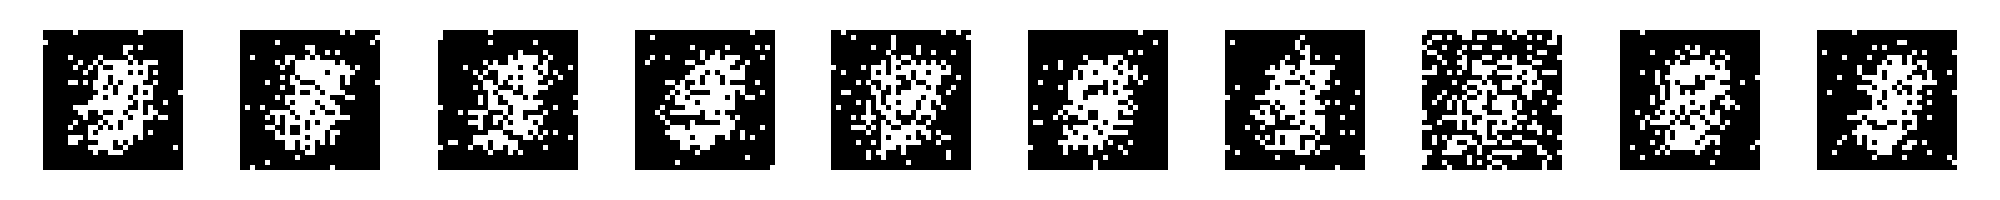

Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [4]:
rbm = RBM(784,100)
fit(rbm, x_train[:6000,:], epochs=5)
rbm.save('rbm_mcmc')

<a id=nmf></a>

# 3. Naive Mean-field Training

## 3.1 Mean-field approximation of the log-likelihood

- Read Section C of the tutorial text and answer corresponding questions!

- Write a function to compute the mean-field likelihood using the 'run_mean_field' function to compute the fixed points of the magnetizations. Similarly to the constrative divergence scheme, we will only run the iteration for a few steps instead of waiting for convergence.

- Once this is done, you can uncomment what is necessary in the MCMC training above to store the mean-field log likelihood.

In [ ]:
def run_mean_field(self, x_init, steps=3):
    '''
    input : input batch (P x N)
    output : input and hidden mean-field means (P x N), (P x M)
    '''
    mx = x_init
    for step in range(steps):
        mh = sigmoid(mx.dot(self.W) + self.b)
        mx = sigmoid(mh.dot(self.W.T) + self.a)
    return mx, mh

def compute_mean_field_likelihood(self, x_batch):
    # First find the mean-field fixed 
    # points in the neighborhood of the batch
###    h1 = sigmoid(x_batch.dot(self.W) + self.b)
###    mx, mh = run_mean_field(self, x_batch)
    
###    eps = 1e-5
###     mx = np.minimum(mx, 1. - eps)
###     mx = np.maximum(mx, eps)
###     mh = np.minimum(mh, 1. - eps)
###     mh = np.maximum(mh, eps)
    
###     # Compute the mean-field -ln Z
###     batchsize = x_batch.shape[0]
###     Hx = - np.sum(mx * np.log(mx) + (1-mx)*(np.log(1-mx)))
###     Hh = - np.sum(mh * np.log(mh) + (1-mh) * (np.log(1-mh)))
###     U = - np.sum(mx.dot(self.W) * mh + self.b * mh) + np.sum(self.a * mx)
###     F_MF = U - (Hx + Hh)
    
###     # Compute exactly -ln (\sum_h exp (-E(x_batch, h))
###     F_data = np.sum(self.a * x_batch)
###     F_data += np.sum(np.log(1+np.exp(x_batch.dot(self.W) + self.b)))
    
###     ell = (F_data - F_MF)/ (x_batch.shape[0] * (self.N + self.M))
    return ell

## 3.2 Training implementation

Now it is your turn to implement the mean-field learning, and launch it! 

Epoch 0


<IPython.core.display.Javascript object>


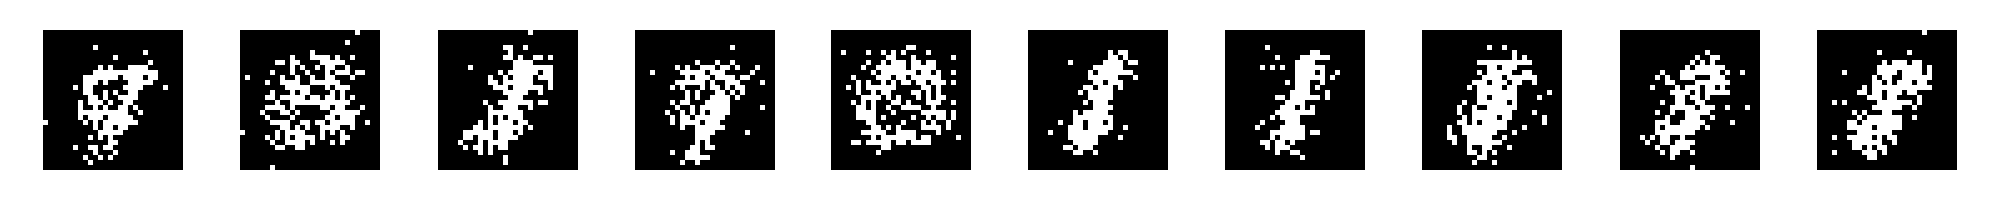

MF loglikelihood 0.6745897486940781
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


<IPython.core.display.Javascript object>


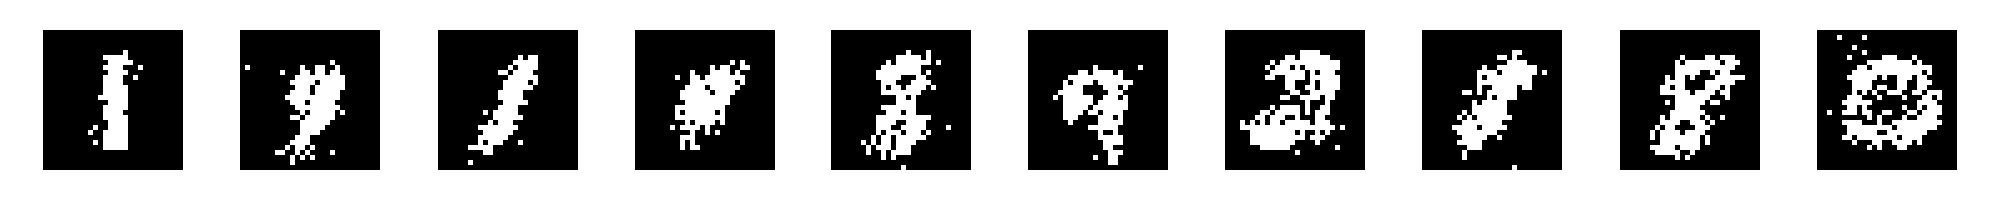

MF loglikelihood 0.9311615843356149
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


<IPython.core.display.Javascript object>


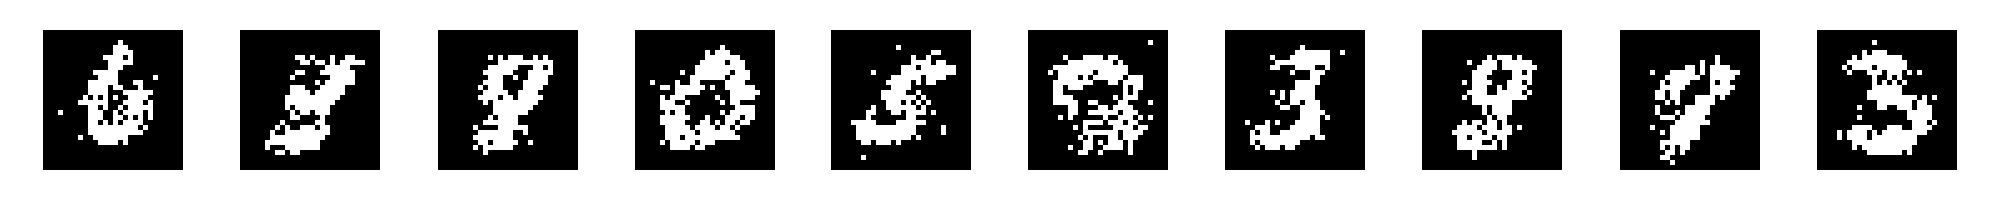

MF loglikelihood 0.9979879016426312
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15


<IPython.core.display.Javascript object>


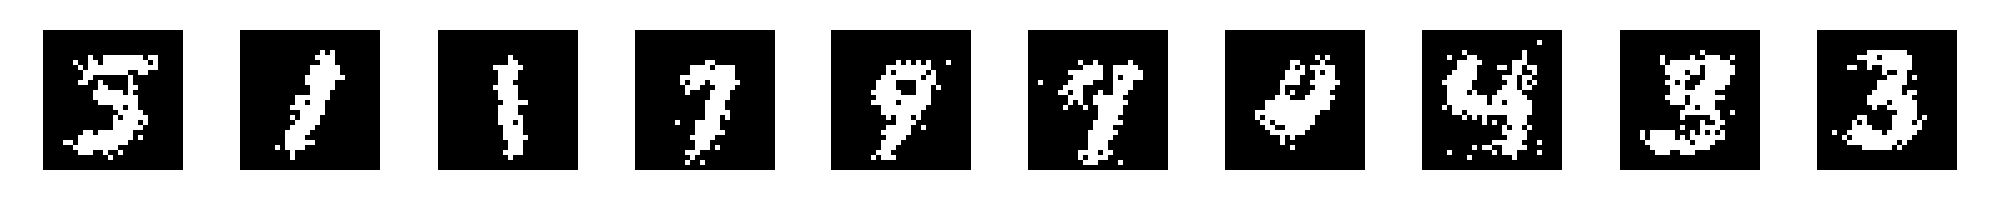

MF loglikelihood 1.0316340247200326
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


<IPython.core.display.Javascript object>


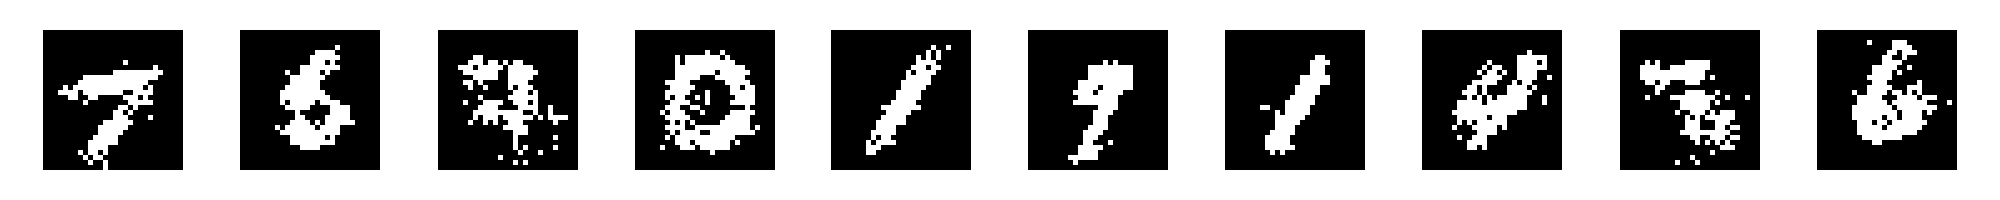

MF loglikelihood 1.034243550380862
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25


<IPython.core.display.Javascript object>


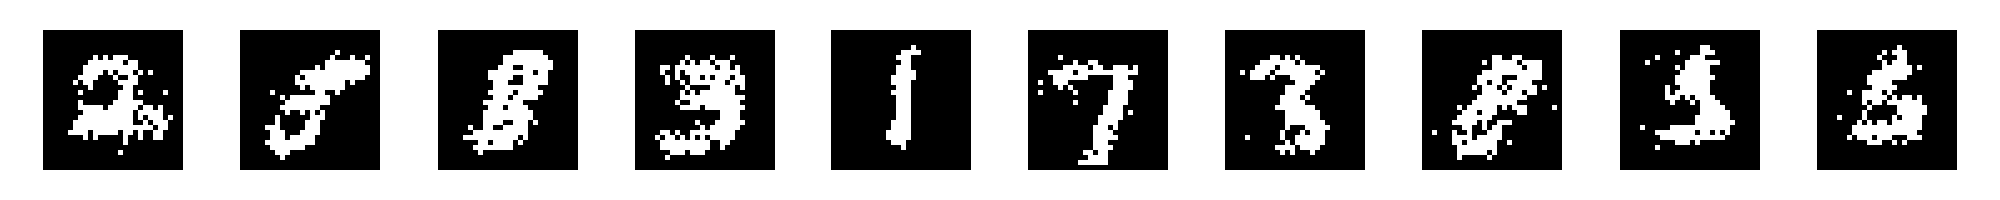

MF loglikelihood 1.0466605400981956
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


<IPython.core.display.Javascript object>


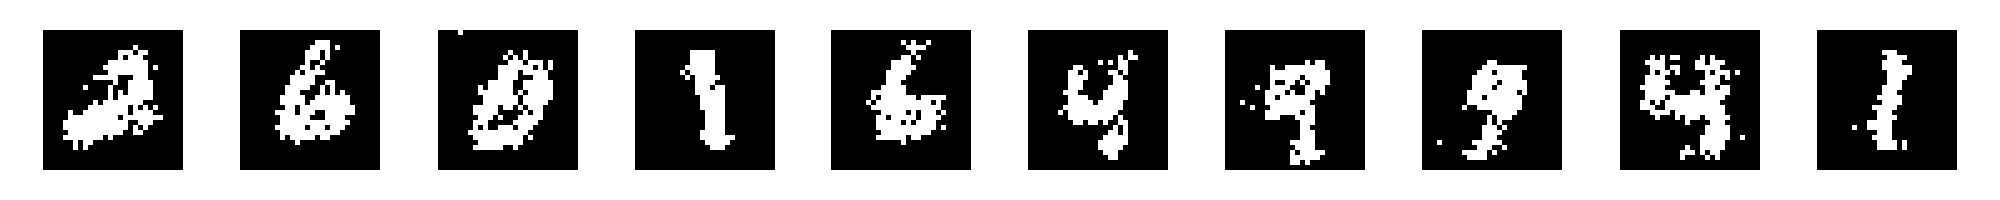

MF loglikelihood 1.0441952317159775
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35


<IPython.core.display.Javascript object>


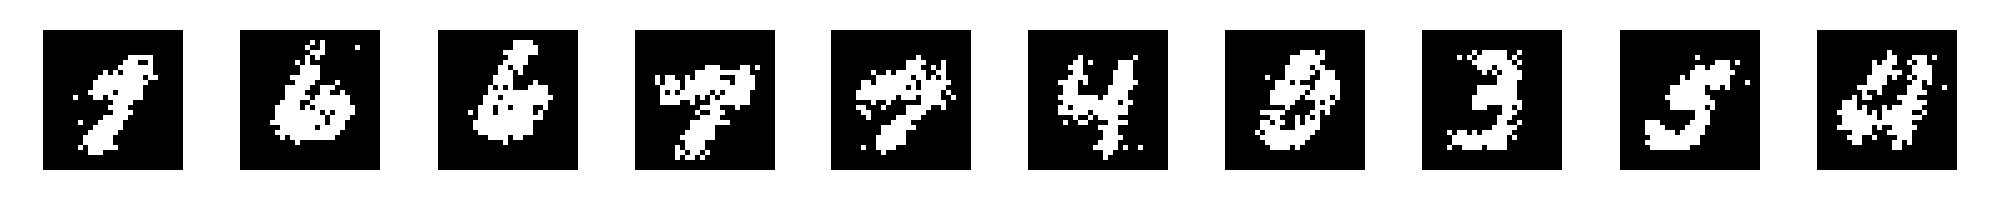

MF loglikelihood 1.0569007173374327
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40


<IPython.core.display.Javascript object>


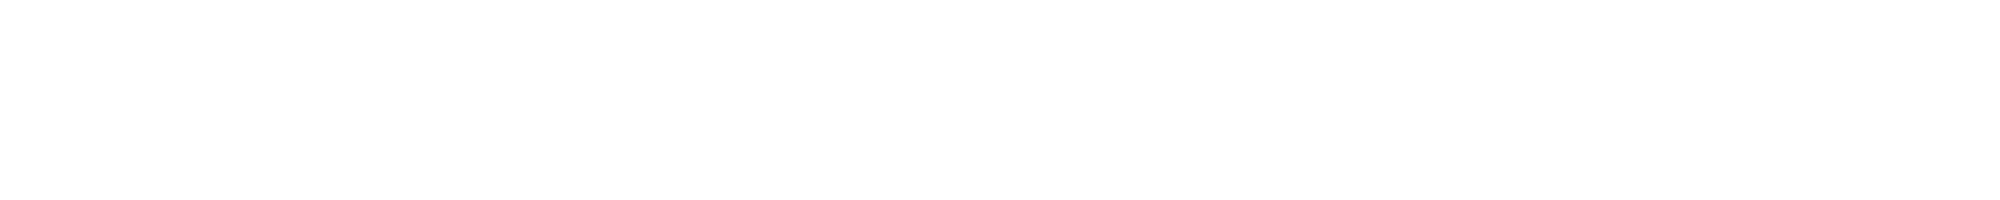

MF loglikelihood 1.0660768535769092
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45


/Users/mgabrie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


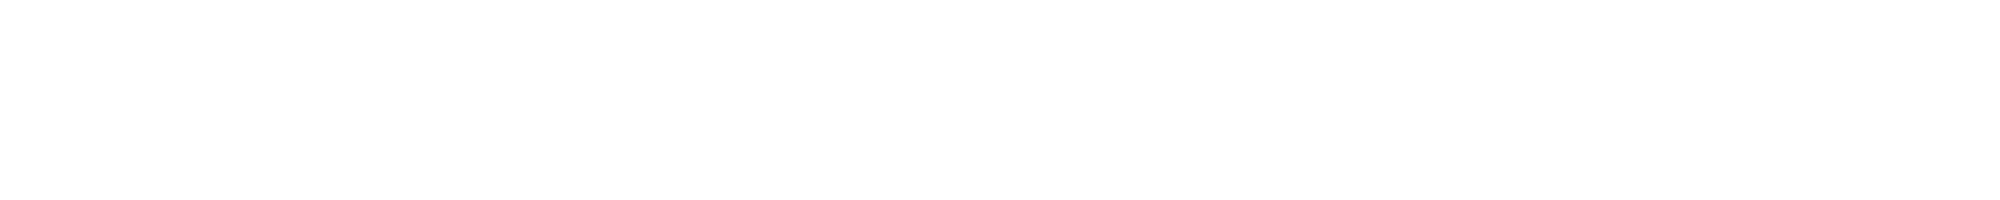

MF loglikelihood 1.070085129683792
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [32]:
def gradient_updates_mean_field(self, x_batch):
###     mh1 = sigmoid(x_batch.dot(self.W) + self.b)
###     mx, mh = run_mean_field(self, x_batch)

###     # not rescaled by the size of the batch
###     DW = np.einsum('ki, ka -> ia', x_batch, mh1)
###     DW -= np.einsum('ki, ka -> ia', mx, mh)
###     self.W = self.W + self.eta * DW

###     Da = np.sum(x_batch - mx, axis=0)
###     self.a = self.a + self.eta * Da

###     Db = np.sum(mh1 - mh, axis=0)
###     self.b = self.b + self.eta * Db
    
    
def fit_mean_field(self, x_train, epochs=10):
##     batch_list = prepare_batches(x_train, 
#                                 self.batch_size)
    
##     ell_init = compute_mean_field_likelihood(self, batch_list[0])
##     self.history = [ell_init]
    
##     for epoch in range(epochs):
##         print("Epoch {:d}".format(epoch))
##         for x_batch in batch_list:
##             gradient_updates_mean_field(self, x_batch)
            
##         ell = compute_mean_field_likelihood(self, x_batch)
##         self.history.append(ell)
        
##         if epoch % 5 == 0:
##             self.plot_mcmc_chains(x_batch)
##             print('MF loglikelihood', ell)
            

In [ ]:
rbm = RBM(784,100)
fit_mean_field(rbm, x_train[:6000,:], epochs=50)
rbm.save('rbm_nmf')

<a id=nmf></a>

# 4. Thouless-Anderson-Palmer Training

Here we propose an implementation for the training based on the TAP approximation. 
- Check that you agree.
- What is different from your naive mean-field code.
- Launch a train to be able to compare this new learning algorithms with the previous ones.

Epoch 0


<IPython.core.display.Javascript object>


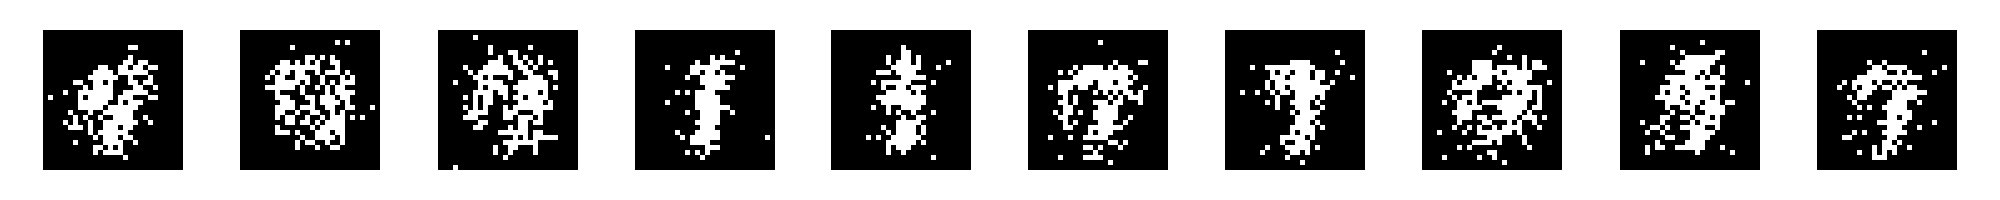

MF loglikelihood 0.6365278368825248
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


<IPython.core.display.Javascript object>


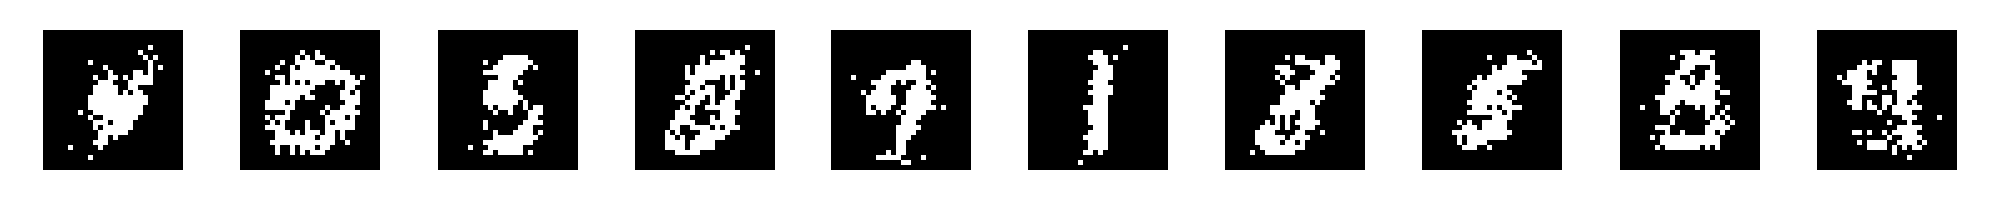

MF loglikelihood 0.9870466645691173
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


<IPython.core.display.Javascript object>


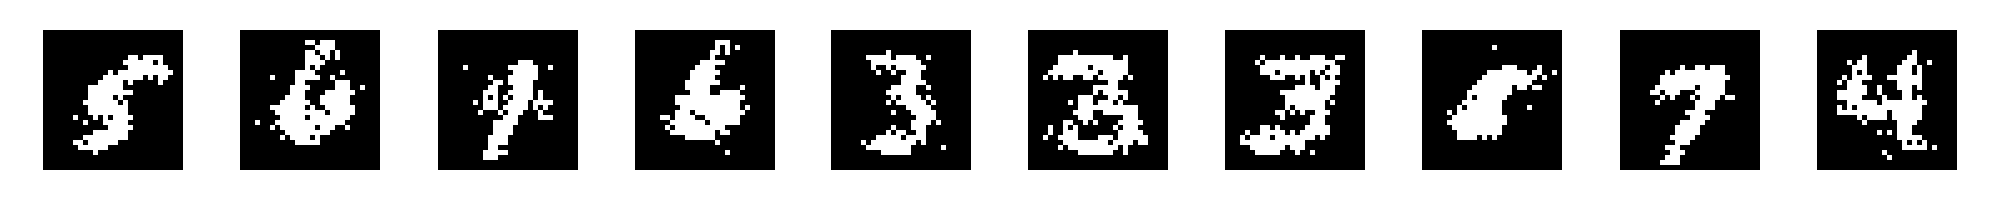

MF loglikelihood 1.0769578082540279
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15


<IPython.core.display.Javascript object>


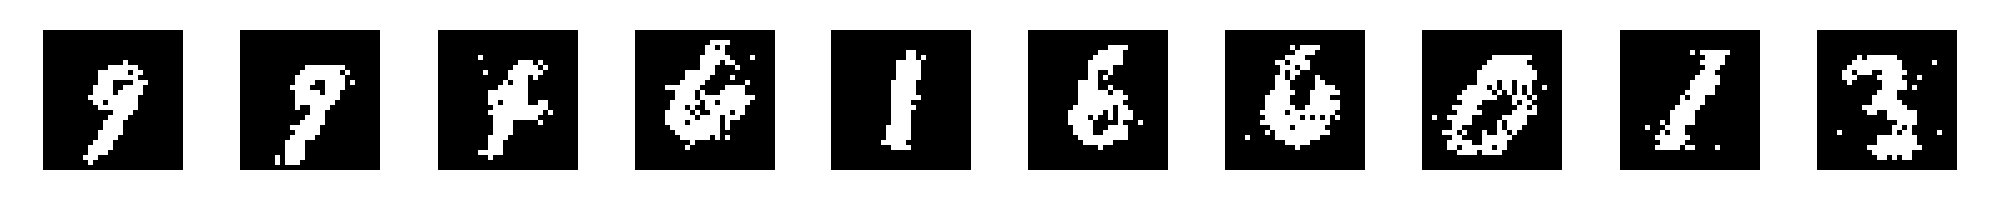

MF loglikelihood 1.1366982618881376
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


<IPython.core.display.Javascript object>


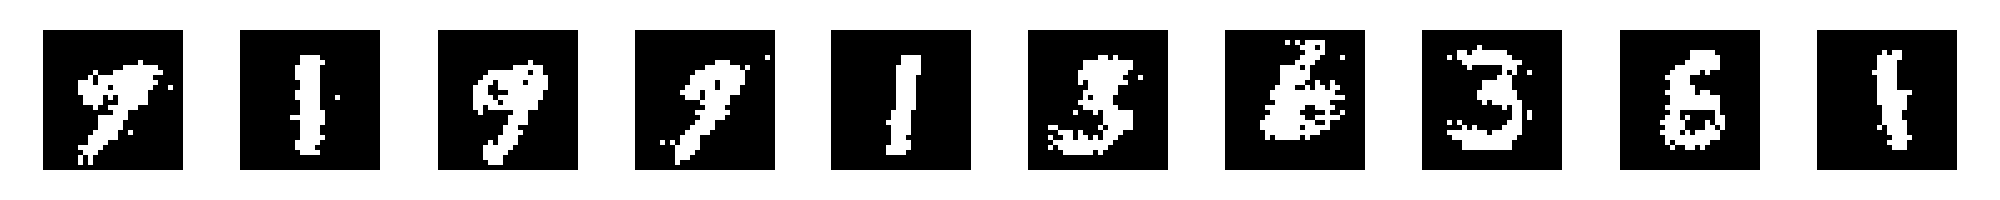

MF loglikelihood 1.1873280577155318
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25


<IPython.core.display.Javascript object>


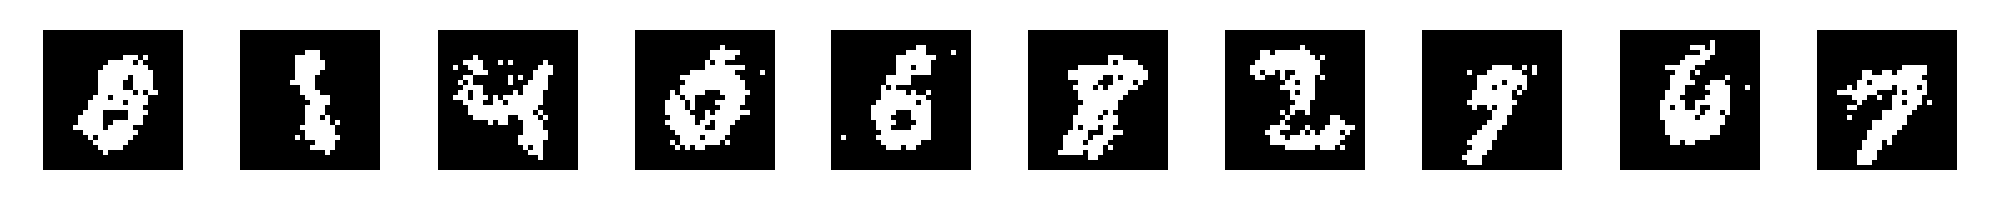

MF loglikelihood 1.2268923144526078
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


<IPython.core.display.Javascript object>


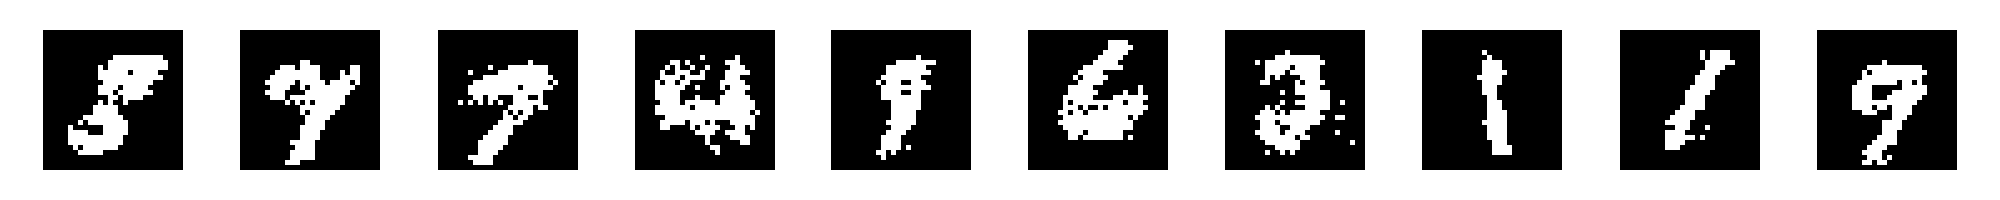

MF loglikelihood 1.2593976793667123
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35


<IPython.core.display.Javascript object>


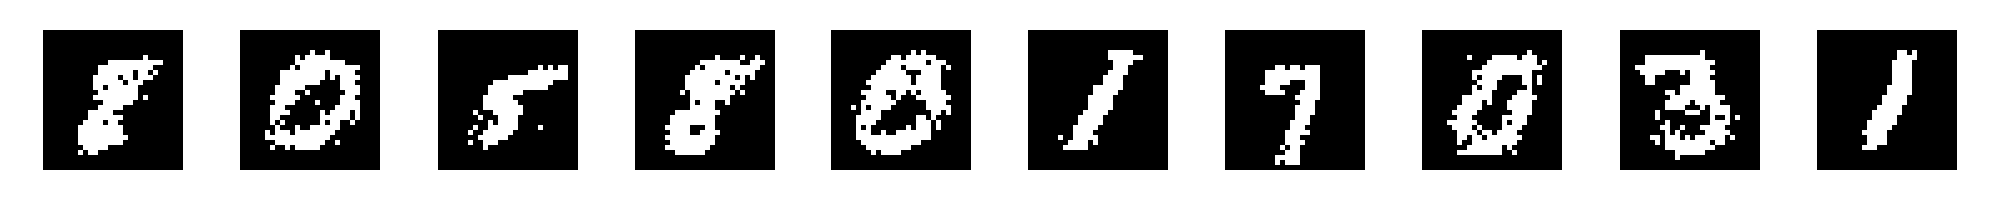

MF loglikelihood 1.2793354026168695
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40


<IPython.core.display.Javascript object>


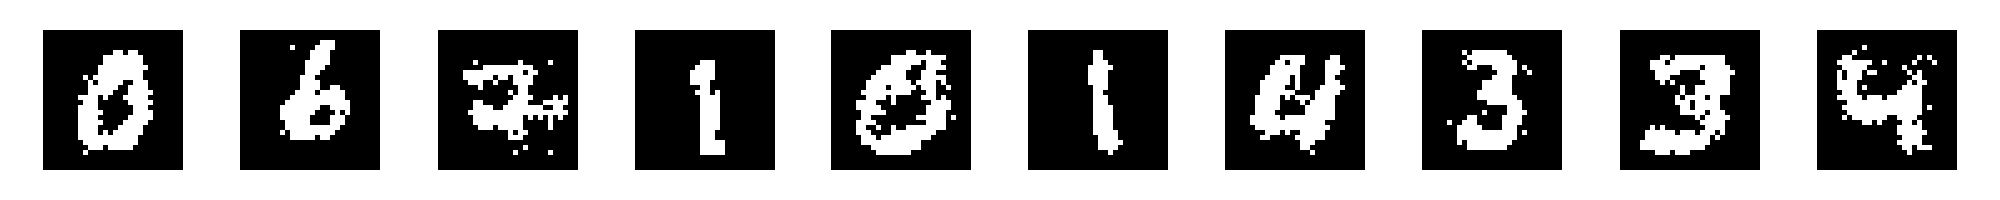

MF loglikelihood 1.2901180543142434
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45


<IPython.core.display.Javascript object>


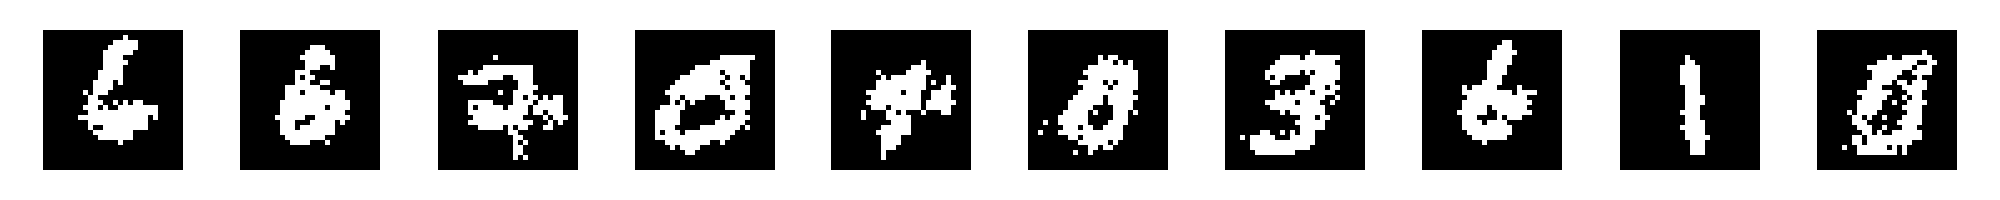

MF loglikelihood 1.3029770743457396
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [30]:
def run_tap(self, x_init, steps=3):
    '''
    input : input batch (P x N)
    output : hidden batch (P x M)
    '''
    mx = x_init
    for step in range(steps):
        onsager = (mx - mx ** 2).dot(self.W**2) * (1/2 - mh)
        mh = sigmoid(mx.dot(self.W) + self.b + onsager)
        onsager =(mh - mh ** 2).dot(self.W**2) * (1/2 - mx)
        mx = sigmoid(mh.dot(self.W.T) + self.a + onsager)
    return mx, mh

def gradient_updates_tap(self, x_batch):
    mh1 = sigmoid(x_batch.dot(self.W) + self.b)
    mx, mh = run_mean_field(self, x_batch)

    # not rescaled by the size of the batch
    DW = np.einsum('ki, ka -> ia', x_batch, mh1)
    DW -= np.einsum('ki, ka -> ia', mx, mh)
    DW += np.einsum('ia, ki, ka -> ia',self.W, mx - mx**2, mh - mh**2)
    self.W = self.W + self.eta * DW - self.eta * self.gamma * self.W

    Da = np.sum(x_batch - mx, axis=0)
    self.a = self.a + self.eta * Da

    Db = np.sum(mh1 - mh, axis=0)
    self.b = self.b + self.eta * Db

    
def fit_tap(self, x_train, epochs=10):
    batch_list = prepare_batches(x_train, 
                                self.batch_size)
    
    ell_init = compute_mean_field_likelihood(self, batch_list[0])
    self.history = [ell_init]
    
    for epoch in range(epochs):
        print("Epoch {:d}".format(epoch))
        
        for x_batch in batch_list:
            gradient_updates_tap(self, x_batch)
            
        ell = compute_mean_field_likelihood(self, x_batch)
        self.history.append(ell)
        
        if epoch % 5 == 0:
            self.plot_mcmc_chains(x_batch)
            print('MF loglikelihood', ell)
            

In [ ]:
rbm = RBM(784,100)
fit_tap(rbm, x_train[:6000,:], epochs=50)
rbm.save('rbm_tap')

<a id=comp><a/>

# 5. Comparison

Now that we have stored the mean-field approxiamtion of the likelihood we can retrieve this information and compare the different algorithms.
- Use the 'load' function defined in [Part 1](#class) to get all the mean-field likelihoods logs from the different types of training.
- Use the matplotlib python package (imported under the alias 'plt') to visualize the comparison.

/Users/mgabrie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


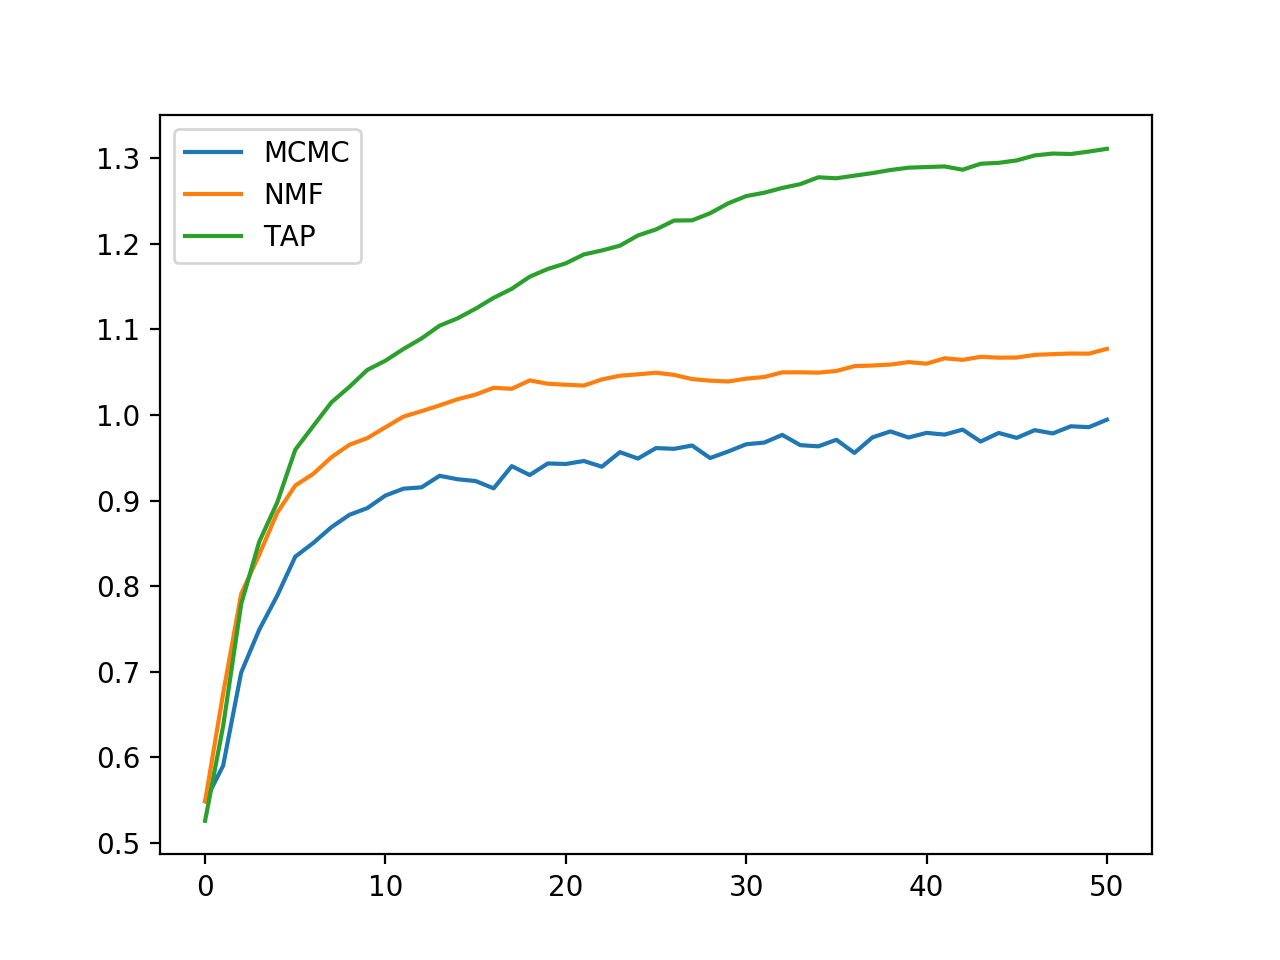

In [40]:
### rbm_mcmc = load('rbm_mcmc.pickle')
### history_mcmc = rbm_mcmc.history

### rbm_mf = load('rbm_nmf.pickle')
### history_mf = rbm_mf.history

### rbm_tap = load('rbm_tap.pickle')
### history_tap = rbm_tap.history

### plt.figure()
### plt.plot(history_mcmc, label='MCMC')
### plt.plot(history_mf, label='NMF')
### plt.plot(history_tap, label='TAP')
### plt.legend()